<a href="https://colab.research.google.com/github/sofiaRaheel/Brain-Tumor-Detection/blob/main/MRI_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install torch torchvision matplotlib


**LIBRARIES**

In [4]:
import os
import random
from collections import Counter

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms



1.   UNDERSTAND DATA
2.   PREPROCESS
3.   MODEL DEVELOPMENT
4.   EVALUATION
5.   EXPLORATION XAI-GRAD CAM



**1.UNDERSTANDING DATA**

In [12]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset



🧠 Training Set Samples:



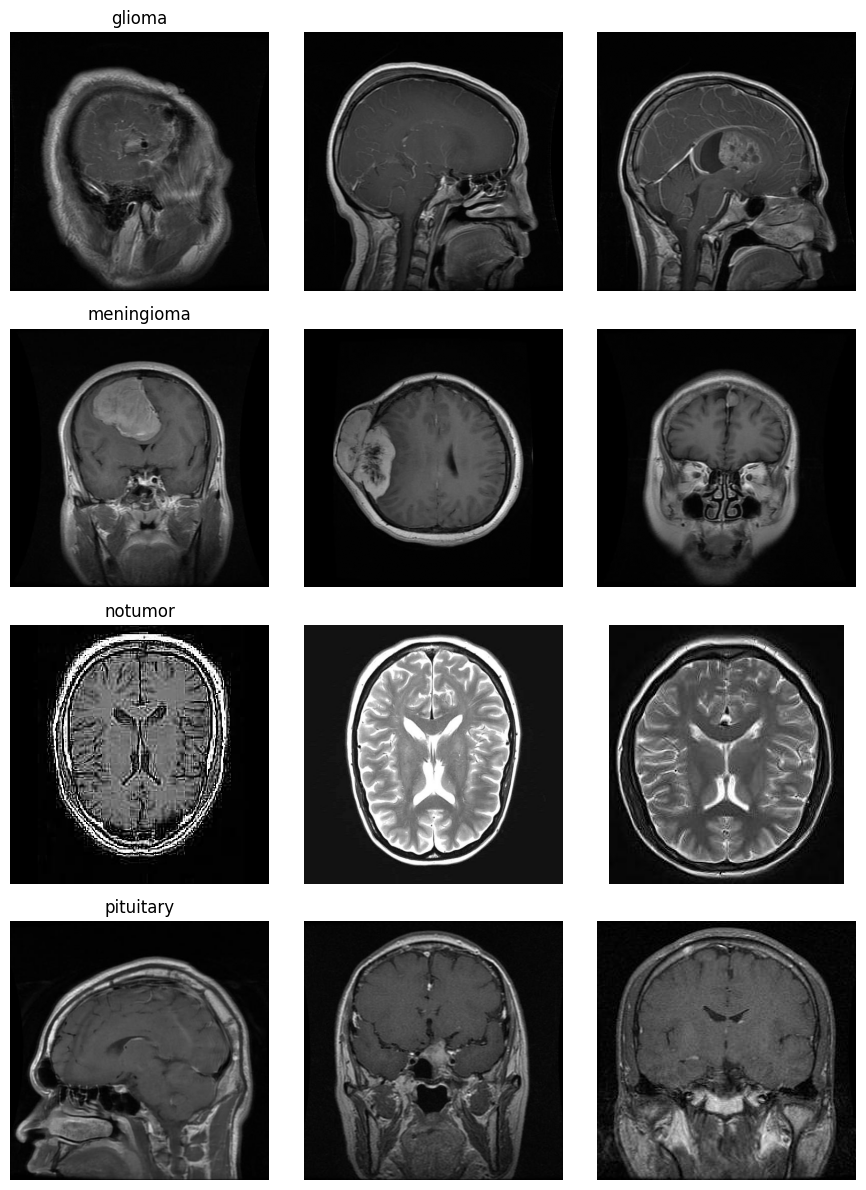


🧠 Testing Set Samples:



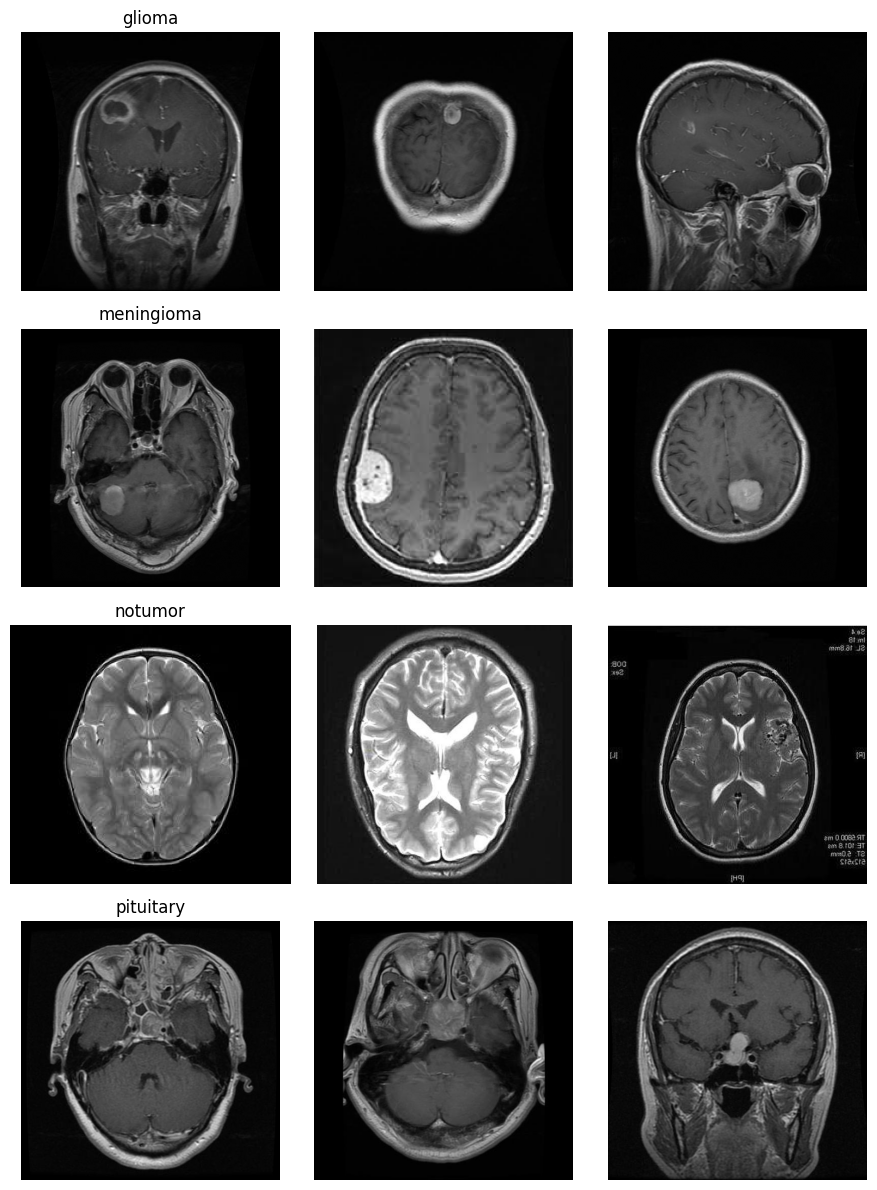

In [13]:
g

In [12]:
# Analyzing Data Set

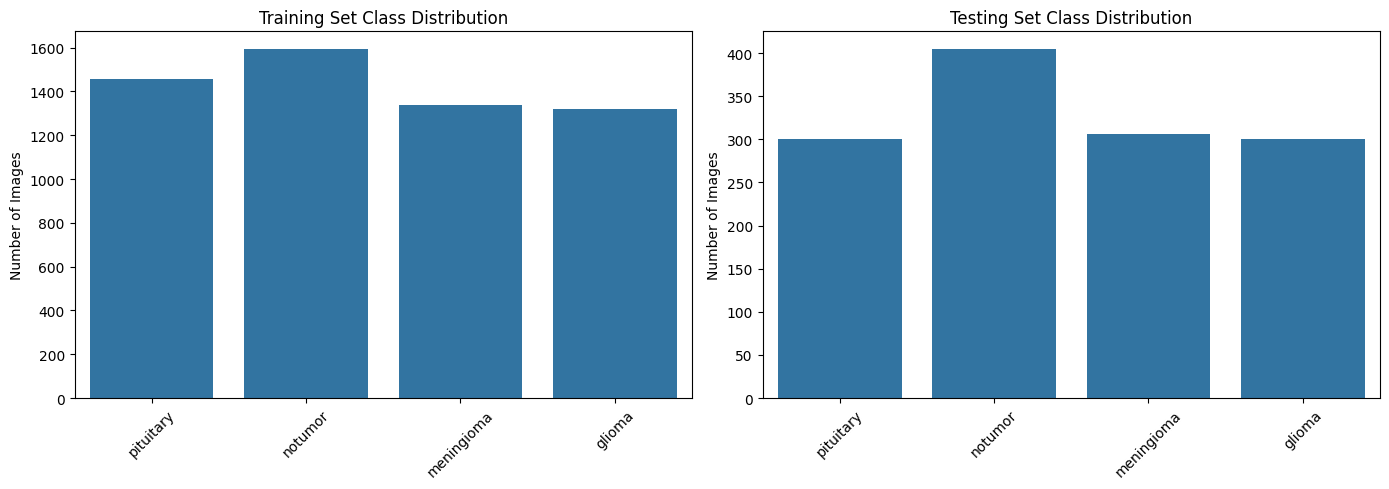

In [14]:
# Prepare class distribution dictionary
class_counts = {"Training": Counter(), "Testing": Counter()}

# Count images in each category
for split in ["Training", "Testing"]:
    split_path = os.path.join(path, split)
    if not os.path.exists(split_path):
        continue

    categories = os.listdir(split_path)
    for category in categories:
        category_path = os.path.join(split_path, category)
        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[split][category] = len(image_files)

# Plotting without warnings
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, split in enumerate(["Training", "Testing"]):
    labels = list(class_counts[split].keys())
    values = [class_counts[split][label] for label in labels]

    sns.barplot(x=labels, y=values, ax=axs[i])
    axs[i].set_title(f"{split} Set Class Distribution")
    axs[i].set_ylabel("Number of Images")
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

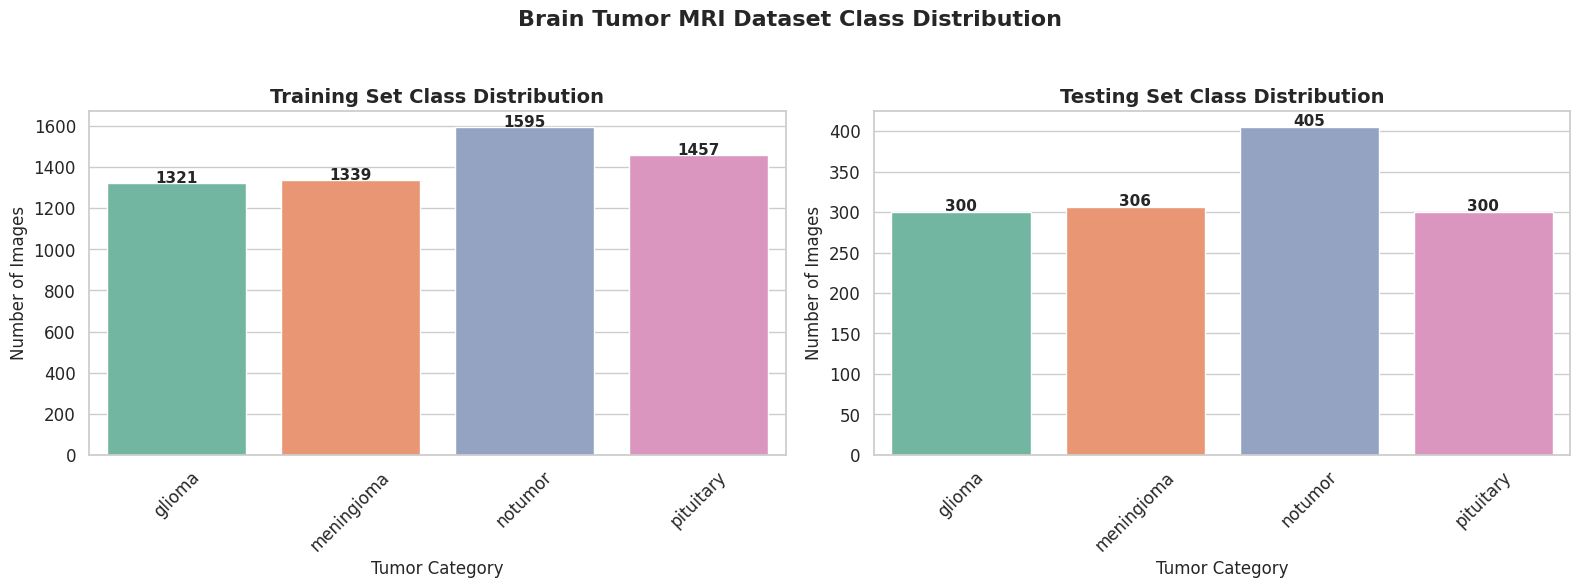

In [21]:
# import seaborn as sns
# from collections import Counter

# # Prepare class distribution dictionary
# class_counts = {"Training": Counter(), "Testing": Counter()}

# # Count images in each category
# for split in ["Training", "Testing"]:
#     split_path = os.path.join(path, split)
#     if not os.path.exists(split_path):
#         continue

#     categories = sorted(os.listdir(split_path))
#     for category in categories:
#         category_path = os.path.join(split_path, category)
#         if os.path.isdir(category_path):
#             image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#             class_counts[split][category] = len(image_files)

# # Seaborn settings
# sns.set(style="whitegrid", font_scale=1.1)
# base_palette = sns.color_palette("Set2")

# # Plotting
# fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# for i, split in enumerate(["Training", "Testing"]):
#     labels = list(class_counts[split].keys())
#     values = [class_counts[split][label] for label in labels]

#     # Use DataFrame so we can pass 'hue' explicitly
#     import pandas as pd
#     df = pd.DataFrame({"Category": labels, "Count": values})

#     # Only use as many colors as there are categories
#     palette = base_palette[:len(labels)]

#     sns.barplot(data=df, x="Category", y="Count", hue="Category", ax=axs[i], palette=palette, legend=False)

#     # Annotate each bar
#     for bar in axs[i].patches:
#         axs[i].text(
#             bar.get_x() + bar.get_width() / 2,
#             bar.get_height() + 2,
#             f'{int(bar.get_height())}',
#             ha='center',
#             fontsize=11,
#             fontweight='bold'
#         )

#     axs[i].set_title(f"{split} Set Class Distribution", fontsize=14, fontweight='bold')
#     axs[i].set_ylabel("Number of Images", fontsize=12)
#     axs[i].set_xlabel("Tumor Category", fontsize=12)
#     axs[i].tick_params(axis='x', rotation=45)

# plt.suptitle("Brain Tumor MRI Dataset Class Distribution", fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


**2.DATA PREPROCESSING**

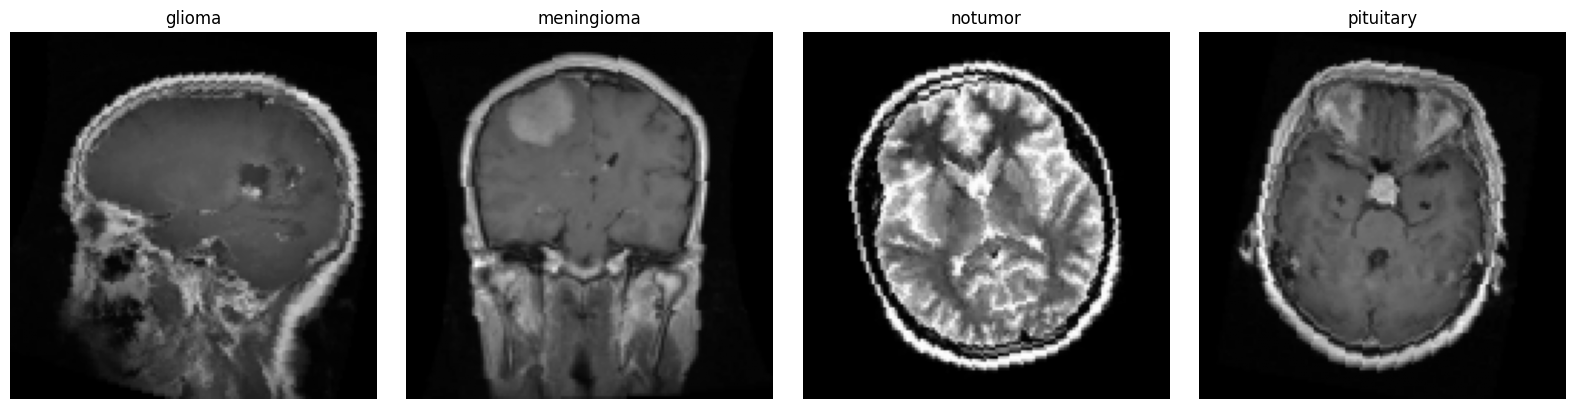

In [19]:
#Transforming pipeline
#horizontal flip--- slight rotation:augmentation
transform=transforms.Compose([transforms.Resize((128,128)),transforms.RandomHorizontalFlip(),transforms.RandomRotation(15), transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])
#rabndom img for display
# training_path = os.path.join(path, "Training")
# categories = os.listdir(training_path)
# sample_class = random.choice(categories)
# sample_class_path = os.path.join(training_path, sample_class)
# sample_image_file = random.choice([
#     f for f in os.listdir(sample_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
# ])
# sample_image_path = os.path.join(sample_class_path, sample_image_file)

# # Load and preprocess image
# image = Image.open(sample_image_path).convert("L")  # Convert to grayscale
# transformed_image = transform(image)

# # Convert back to numpy image for display
# untransformed = transformed_image * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
# untransformed_np = untransformed.squeeze().numpy()  # Remove channel dim

# # Show image
# plt.imshow(untransformed_np, cmap='gray')
# plt.title(f"Preprocessed Sample from '{sample_class}'")
# plt.axis('off')
# plt.show()
# Training set path
training_path = os.path.join(path, "Training")
categories = sorted(os.listdir(training_path))

# Plot settings
fig, axs = plt.subplots(1, len(categories), figsize=(4 * len(categories), 4))

# One image per category
for i, category in enumerate(categories):
    category_path = os.path.join(training_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        continue

    # Pick one image
    img_path = os.path.join(category_path, random.choice(image_files))
    image = Image.open(img_path).convert("L")  # Convert to grayscale

    # Apply transform
    transformed = transform(image)

    # Convert back to display format
    img_disp = transformed * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    img_np = img_disp.squeeze().numpy()

    # Show image
    axs[i].imshow(img_np, cmap='gray')
    axs[i].set_title(category)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


**3.MODEL DEVELOPMENT & EVALUATION**

RESNET

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training: 100%|██████████| 179/179 [00:32<00:00,  5.44it/s]


Train Loss: 0.8766 Acc: 0.6434


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.32it/s]


Val Loss: 0.6309 Acc: 0.7635
Epoch 2/15
----------


Training: 100%|██████████| 179/179 [00:31<00:00,  5.72it/s]


Train Loss: 0.6882 Acc: 0.7255


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.19it/s]


Val Loss: 0.6060 Acc: 0.7689
Epoch 3/15
----------


Training: 100%|██████████| 179/179 [00:31<00:00,  5.74it/s]


Train Loss: 0.6541 Acc: 0.7467


Validation: 100%|██████████| 41/41 [00:05<00:00,  6.99it/s]


Val Loss: 0.4974 Acc: 0.7956
Epoch 4/15
----------


Training: 100%|██████████| 179/179 [00:31<00:00,  5.62it/s]


Train Loss: 0.6063 Acc: 0.7560


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.48it/s]


Val Loss: 0.5620 Acc: 0.7788
Epoch 5/15
----------


Training: 100%|██████████| 179/179 [00:32<00:00,  5.54it/s]


Train Loss: 0.6090 Acc: 0.7579


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.62it/s]


Val Loss: 0.4799 Acc: 0.8009
Epoch 6/15
----------


Training: 100%|██████████| 179/179 [00:33<00:00,  5.30it/s]


Train Loss: 0.5437 Acc: 0.7908


Validation: 100%|██████████| 41/41 [00:09<00:00,  4.16it/s]


Val Loss: 0.4891 Acc: 0.7979
Epoch 7/15
----------


Training: 100%|██████████| 179/179 [00:32<00:00,  5.45it/s]


Train Loss: 0.5341 Acc: 0.7901


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.00it/s]


Val Loss: 0.4871 Acc: 0.8002
Epoch 8/15
----------


Training: 100%|██████████| 179/179 [00:33<00:00,  5.42it/s]


Train Loss: 0.5347 Acc: 0.7892


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.01it/s]


Val Loss: 0.5011 Acc: 0.7994
Epoch 9/15
----------


Training: 100%|██████████| 179/179 [00:32<00:00,  5.44it/s]


Train Loss: 0.5230 Acc: 0.7976


Validation: 100%|██████████| 41/41 [00:06<00:00,  5.95it/s]


Val Loss: 0.4855 Acc: 0.8032
Epoch 10/15
----------


Training: 100%|██████████| 179/179 [00:36<00:00,  4.88it/s]


Train Loss: 0.5160 Acc: 0.7976


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.21it/s]


Val Loss: 0.4840 Acc: 0.8009
Epoch 11/15
----------


Training: 100%|██████████| 179/179 [00:37<00:00,  4.77it/s]


Train Loss: 0.5171 Acc: 0.8004


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]


Val Loss: 0.4835 Acc: 0.8017
Epoch 12/15
----------


Training: 100%|██████████| 179/179 [00:37<00:00,  4.74it/s]


Train Loss: 0.5217 Acc: 0.7969


Validation: 100%|██████████| 41/41 [00:07<00:00,  5.46it/s]


Val Loss: 0.4822 Acc: 0.8063
Epoch 13/15
----------


Training: 100%|██████████| 179/179 [00:36<00:00,  4.92it/s]


Train Loss: 0.5185 Acc: 0.7950


Validation: 100%|██████████| 41/41 [00:07<00:00,  5.76it/s]


Val Loss: 0.4888 Acc: 0.7994
Epoch 14/15
----------


Training: 100%|██████████| 179/179 [00:37<00:00,  4.77it/s]


Train Loss: 0.5172 Acc: 0.7985


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]


Val Loss: 0.4836 Acc: 0.8002
Epoch 15/15
----------


Training: 100%|██████████| 179/179 [00:37<00:00,  4.78it/s]


Train Loss: 0.5159 Acc: 0.7981


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.07it/s]


Val Loss: 0.4792 Acc: 0.8002


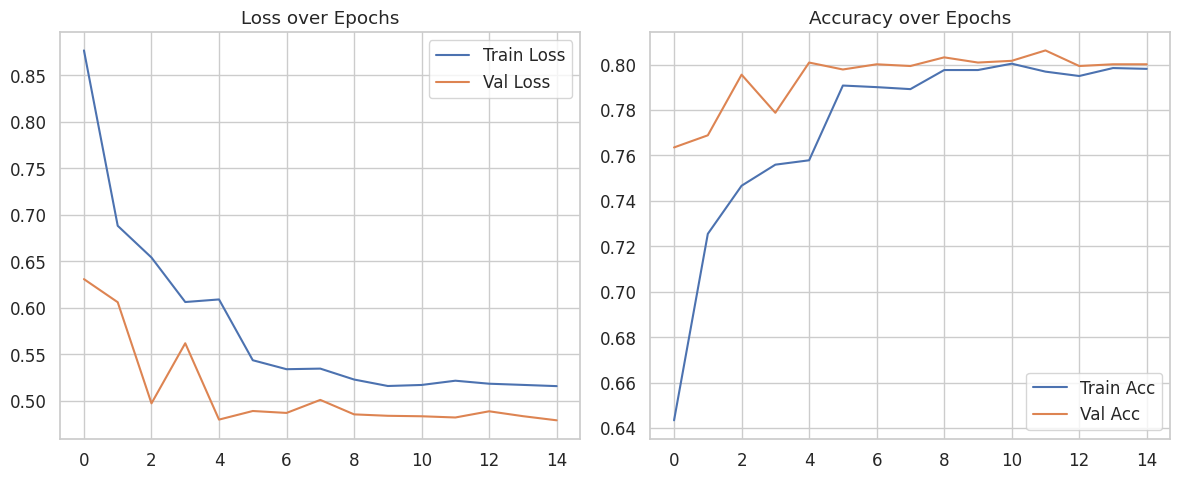

Classification Report:
              precision    recall  f1-score   support

      glioma       0.78      0.86      0.82       300
  meningioma       0.68      0.46      0.55       306
     notumor       0.82      0.96      0.89       405
   pituitary       0.87      0.87      0.87       300

    accuracy                           0.80      1311
   macro avg       0.79      0.79      0.78      1311
weighted avg       0.79      0.80      0.79      1311



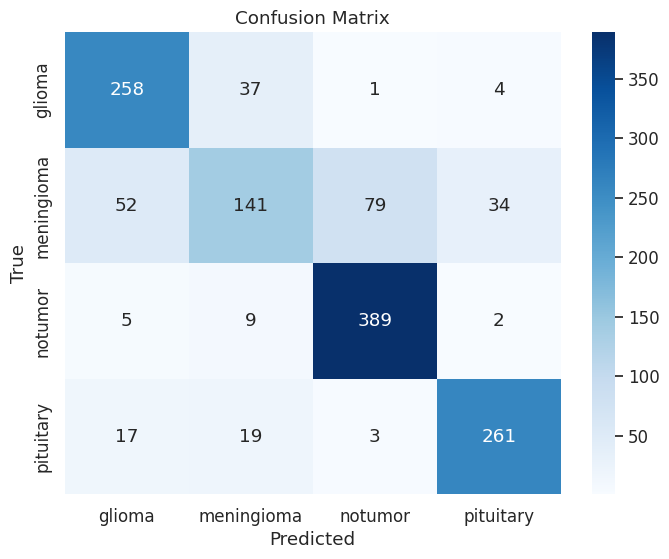

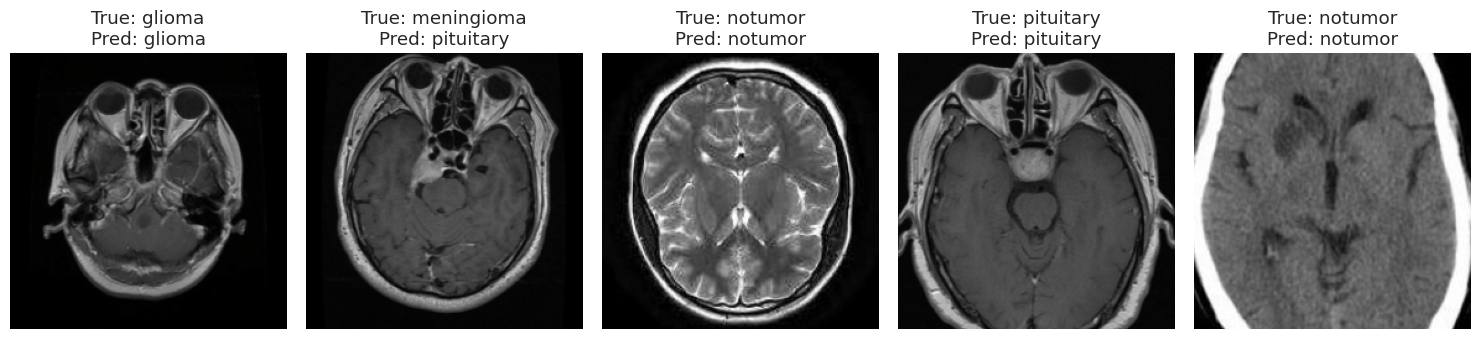

In [24]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Create PyTorch Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='Training'):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = sorted(os.listdir(self.root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    images.append((img_path, self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Define Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. Create Datasets and DataLoaders
train_dataset = BrainTumorDataset(path, transform=data_transforms['train'], split='Training')
test_dataset = BrainTumorDataset(path, transform=data_transforms['test'], split='Testing')

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 4. Initialize ResNet Model
def create_model(num_classes=4):
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

    return model.to(device)

model = create_model()
print(model)

# 5. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 6. Fixed Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=15):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double().cpu().numpy() / len(train_dataset)  # Fixed: move to cpu before numpy
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Validation"):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects.double().cpu().numpy() / len(test_dataset)  # Fixed: move to cpu before numpy
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Update learning rate
        scheduler.step()

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model_resnet.pth')

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# 7. Train the Model
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=15)

# 8. Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # Fixed: move to cpu before numpy
            all_labels.extend(labels.cpu().numpy())  # Fixed: move to cpu before numpy

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(trained_model, test_loader)

# 9. Interpret Predictions
def show_predictions(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)

        # Convert image back for display
        image = image.squeeze().cpu().numpy()  # Fixed: move to cpu before numpy
        image = np.transpose(image, (1, 2, 0))
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'True: {test_dataset.classes[label]}\nPred: {test_dataset.classes[pred.item()]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(trained_model, test_dataset)

IMPROVED RESNET W/ enhanced architecture(Kamining Uniform intialization fro weights),strategic layer freezing, batchNorm w/ higher dropout rate, Advanced Training (AdamWoptimizer, cosine annealing lr, early stopping patinec,class weighted closs), beter processing (aggressive augumentation),  increased epochs


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training: 100%|██████████| 179/179 [01:03<00:00,  2.80it/s]


Train Loss: 0.5074 Acc: 0.8109


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]


Val Loss: 0.4287 Acc: 0.8330
Saved new best model
Epoch 2/50
----------


Training: 100%|██████████| 179/179 [00:56<00:00,  3.16it/s]


Train Loss: 0.2690 Acc: 0.9084


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.76it/s]


Val Loss: 0.2609 Acc: 0.9054
Saved new best model
Epoch 3/50
----------


Training: 100%|██████████| 179/179 [00:53<00:00,  3.32it/s]


Train Loss: 0.2084 Acc: 0.9282


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.21it/s]


Val Loss: 0.2307 Acc: 0.9092
Saved new best model
Epoch 4/50
----------


Training: 100%|██████████| 179/179 [00:53<00:00,  3.32it/s]


Train Loss: 0.1862 Acc: 0.9331


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.18it/s]


Val Loss: 0.2079 Acc: 0.9161
Saved new best model
Epoch 5/50
----------


Training: 100%|██████████| 179/179 [00:55<00:00,  3.24it/s]


Train Loss: 0.1605 Acc: 0.9464


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.36it/s]


Val Loss: 0.1973 Acc: 0.9260
Saved new best model
Epoch 6/50
----------


Training: 100%|██████████| 179/179 [01:03<00:00,  2.82it/s]


Train Loss: 0.1291 Acc: 0.9585


Validation: 100%|██████████| 41/41 [00:08<00:00,  5.04it/s]


Val Loss: 0.2095 Acc: 0.9283
Saved new best model
Epoch 7/50
----------


Training: 100%|██████████| 179/179 [01:11<00:00,  2.49it/s]


Train Loss: 0.1222 Acc: 0.9622


Validation: 100%|██████████| 41/41 [00:07<00:00,  5.72it/s]


Val Loss: 0.2449 Acc: 0.9123
Epoch 8/50
----------


Training: 100%|██████████| 179/179 [01:02<00:00,  2.85it/s]


Train Loss: 0.1100 Acc: 0.9617


Validation: 100%|██████████| 41/41 [00:08<00:00,  4.77it/s]


Val Loss: 0.1331 Acc: 0.9519
Saved new best model
Epoch 9/50
----------


Training: 100%|██████████| 179/179 [01:06<00:00,  2.70it/s]


Train Loss: 0.0956 Acc: 0.9699


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.28it/s]


Val Loss: 0.1209 Acc: 0.9527
Saved new best model
Epoch 10/50
----------


Training: 100%|██████████| 179/179 [00:54<00:00,  3.30it/s]


Train Loss: 0.0964 Acc: 0.9685


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.72it/s]


Val Loss: 0.1184 Acc: 0.9573
Saved new best model
Epoch 11/50
----------


Training: 100%|██████████| 179/179 [00:54<00:00,  3.29it/s]


Train Loss: 0.0779 Acc: 0.9767


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.23it/s]


Val Loss: 0.1046 Acc: 0.9619
Saved new best model
Epoch 12/50
----------


Training: 100%|██████████| 179/179 [00:57<00:00,  3.10it/s]


Train Loss: 0.0724 Acc: 0.9767


Validation: 100%|██████████| 41/41 [00:07<00:00,  5.57it/s]


Val Loss: 0.1181 Acc: 0.9603
Epoch 13/50
----------


Training: 100%|██████████| 179/179 [00:55<00:00,  3.24it/s]


Train Loss: 0.0694 Acc: 0.9799


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.90it/s]


Val Loss: 0.1062 Acc: 0.9641
Saved new best model
Epoch 14/50
----------


Training: 100%|██████████| 179/179 [00:53<00:00,  3.36it/s]


Train Loss: 0.0680 Acc: 0.9797


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.39it/s]


Val Loss: 0.1040 Acc: 0.9687
Saved new best model
Epoch 15/50
----------


Training: 100%|██████████| 179/179 [00:54<00:00,  3.26it/s]


Train Loss: 0.0701 Acc: 0.9774


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.33it/s]


Val Loss: 0.0909 Acc: 0.9687
Epoch 16/50
----------


Training: 100%|██████████| 179/179 [00:59<00:00,  3.01it/s]


Train Loss: 0.0648 Acc: 0.9793


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.47it/s]


Val Loss: 0.0998 Acc: 0.9657
Epoch 17/50
----------


Training: 100%|██████████| 179/179 [00:53<00:00,  3.36it/s]


Train Loss: 0.0611 Acc: 0.9809


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.80it/s]


Val Loss: 0.1009 Acc: 0.9649
Epoch 18/50
----------


Training: 100%|██████████| 179/179 [00:53<00:00,  3.35it/s]


Train Loss: 0.0634 Acc: 0.9802


Validation: 100%|██████████| 41/41 [00:06<00:00,  6.38it/s]


Val Loss: 0.1111 Acc: 0.9611
Epoch 19/50
----------


Training: 100%|██████████| 179/179 [00:53<00:00,  3.35it/s]


Train Loss: 0.0598 Acc: 0.9807


Validation: 100%|██████████| 41/41 [00:05<00:00,  7.79it/s]


Val Loss: 0.1041 Acc: 0.9657
Early stopping triggered after 5 epochs without improvement


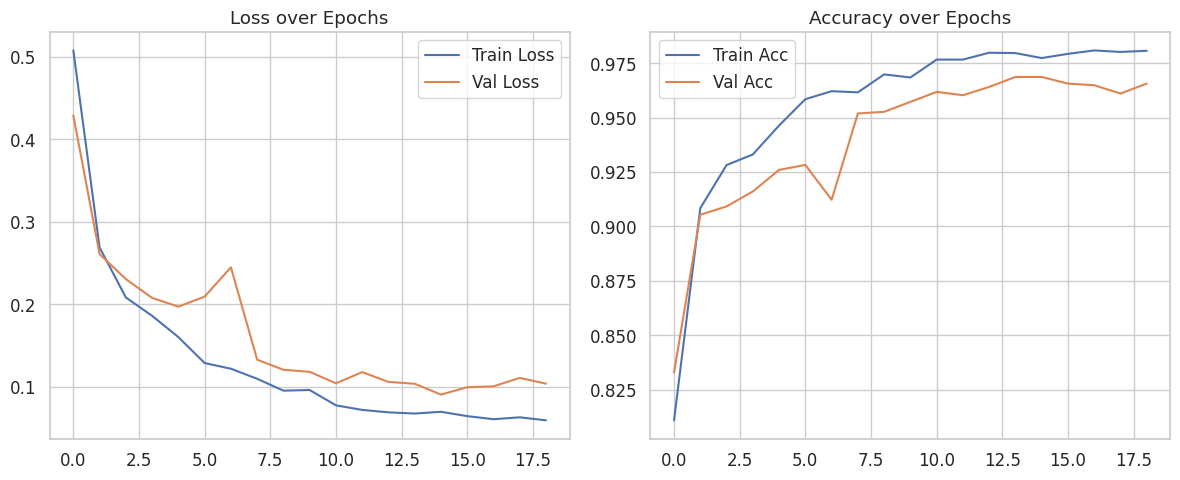

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       300
  meningioma       0.97      0.92      0.94       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



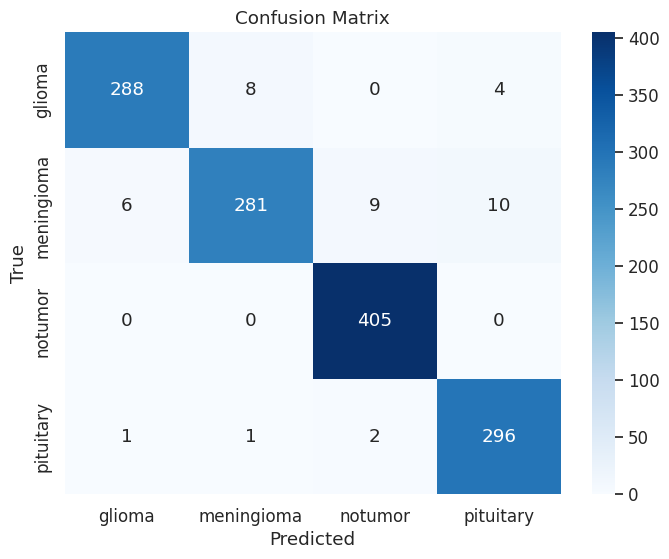

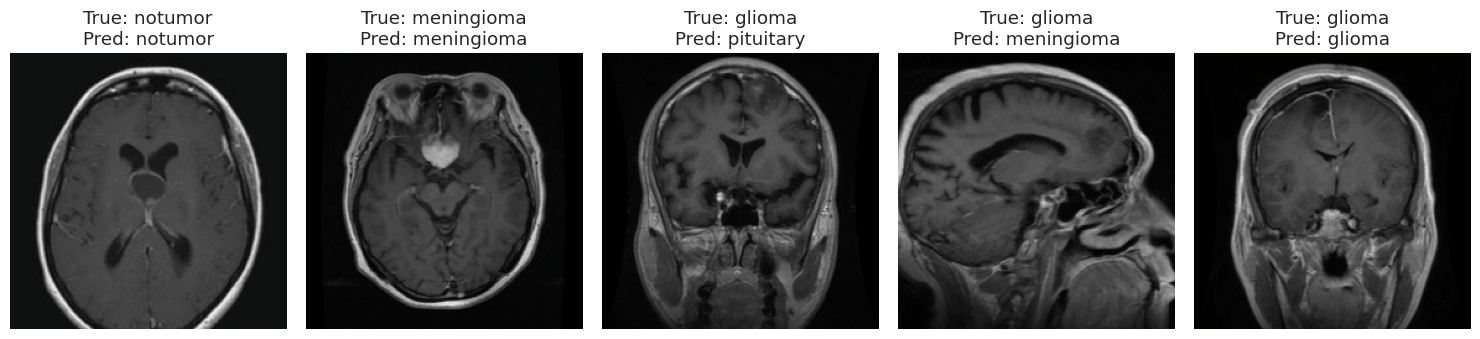

In [25]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Enhanced Dataset Class with Class Weight Calculation
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='Training'):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = sorted(os.listdir(self.root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()
        self.class_counts = self._get_class_counts()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    images.append((img_path, self.class_to_idx[class_name]))
        return images

    def _get_class_counts(self):
        counts = [0] * len(self.classes)
        for _, label in self.images:
            counts[label] += 1
        return counts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Enhanced Data Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=(3,3)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. Create Datasets and DataLoaders
train_dataset = BrainTumorDataset(path, transform=data_transforms['train'], split='Training')
test_dataset = BrainTumorDataset(path, transform=data_transforms['test'], split='Testing')

# Calculate class weights for imbalanced data
class_weights = 1. / torch.tensor(train_dataset.class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 4. Improved Model Architecture (Fixed weights specification)
def create_improved_model(num_classes=4):
    # Load pre-trained ResNet18 with correct weights
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Strategic layer freezing
    for name, param in model.named_parameters():
        if 'layer4' not in name and 'fc' not in name:
            param.requires_grad = False

    # Enhanced classifier head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

model = create_improved_model()
print(model)

# 5. Enhanced Training Setup
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

# 6. Improved Training Function with Early Stopping
def train_improved_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    patience = 5
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = (running_corrects.double() / len(train_dataset)).cpu().numpy()  # Move to CPU before numpy
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Validation"):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = (running_corrects.double() / len(test_dataset)).cpu().numpy()  # Move to CPU before numpy
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping logic
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_improved.pth')
            print("Saved new best model")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# 7. Train the Improved Model
trained_model = train_improved_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

# 8. Evaluation Functions
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def show_predictions(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)

        image = image.squeeze().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'True: {test_dataset.classes[label]}\nPred: {test_dataset.classes[pred.item()]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 9. Load Best Model and Evaluate
model.load_state_dict(torch.load('best_model_improved.pth'))
evaluate_model(model, test_loader)
show_predictions(model, test_dataset)

CNN (SCRATCH IMPLEMENTATION):
(gelu activation for medical images, stochastic depth reg, light weight attention mechanism, orthogonal weight initialization), Enhanced Data pipeline(random affine (spatial aug), RandomErasing for occlusion, aggressive color jittering,OneCycleLR scheduler for faster convergence,Label smoothing for better calibration, Higher initial learning rate with proper decay/)

accuracy/this run may not be as optimal due to environment change to cpu--- due to gpu limit :(

In [1]:


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset Class (same as your ResNet example)
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='Training'):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = sorted(os.listdir(self.root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()
        self.class_counts = self._get_class_counts()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    images.append((img_path, self.class_to_idx[class_name]))
        return images

    def _get_class_counts(self):
        counts = [0] * len(self.classes)
        for _, label in self.images:
            counts[label] += 1
        return counts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Data Augmentation (same as your ResNet example)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=(3,3)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and dataloaders
path = '/kaggle/input/brain-tumor-mri-dataset'  # Replace with your actual path
train_dataset = BrainTumorDataset(path, transform=data_transforms['train'], split='Training')
test_dataset = BrainTumorDataset(path, transform=data_transforms['test'], split='Testing')

# Calculate class weights for imbalanced data
class_weights = 1. / torch.tensor(train_dataset.class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# CNN-from-scratch model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        # Feature extraction
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize model
model = BrainTumorCNN(num_classes=len(train_dataset.classes)).to(device)
print(model)

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

# Training function with evaluation and visualization
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    patience = 5
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = (running_corrects.double() / len(train_dataset)).cpu().numpy()
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Validation"):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = (running_corrects.double() / len(test_dataset)).cpu().numpy()
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Early stopping logic
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print("Saved new best model")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    return model

# Evaluation functions
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()

def show_predictions(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)

        image = image.squeeze().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'True: {test_dataset.classes[label]}\nPred: {test_dataset.classes[pred.item()]}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

# Train the model
print("Starting training...")
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

# Load best model and evaluate
print("\nEvaluating best model...")
model.load_state_dict(torch.load('best_cnn_model.pth'))
evaluate_model(model, test_loader, train_dataset.classes)
show_predictions(model, test_dataset)

# Show sample images from dataset
def show_dataset_samples(dataset, num_samples=5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'Class: {dataset.classes[label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('dataset_samples.png')
    plt.show()

print("\nSample training images:")
show_dataset_samples(train_dataset)
print("\nSample test images:")
show_dataset_samples(test_dataset)

IMPROVED CNN

In [ ]:
PART 2 -- SECOND NOTEBOOK CONTINUE

**GRAD CAM**